Relative Self-Attention
====

## Setup: Define tensors and the embedding layer

In [1]:
import torch
import torch.nn as nn

seq_len = 12
d = 512
W_q = torch.randn(d, d)
W_k = torch.randn(d, d)
W_v = torch.randn(d, d)

clip = 7
embedding = nn.Embedding(2 * clip + 1, d)
print('embedding:', embedding)

X = torch.randn((seq_len, d))
Q = X.matmul(W_q)
K = X.matmul(W_k)
V = X.matmul(W_v)

print('Q:', Q.shape)
print('K:', K.shape)
print('V:', V.shape)

embedding: Embedding(15, 512)
Q: torch.Size([12, 512])
K: torch.Size([12, 512])
V: torch.Size([12, 512])


## Approach 1

"Self-Attention with Relative Position Representations", P. Shaw et al., 2018.

 * Standard attention scores
 
$$\text{attention_scores}=QK^\top$$

 * Relative attention scores
 
 $$\text{relative_scores}=\bar{\boldsymbol{Q}}\boldsymbol{R}^\top$$
 
 * Attention output
 
 $$\text{Attention(Q,K,V)}=\text{Softmax}\left(\frac{QK^\top + \bar{\boldsymbol{Q}}\boldsymbol{R}^\top}{\sqrt{d}}\right)V$$

In [2]:
# step 1: standard attention scores
attention_scores = torch.matmul(Q, K.transpose(-2, -1))
attention_scores.shape


torch.Size([12, 12])

### Get relative position embeddings

In [3]:
# step 2: relative position scores

positions = torch.arange(seq_len)

relative_positions = positions.unsqueeze(-1) - positions.unsqueeze(-2)
print('relative_positions:', relative_positions.shape)
print(relative_positions)

# Clip the relative positions
clipped_relative_positions = torch.clamp(relative_positions, -clip, clip)
print('clipped_relative_positions:\n', clipped_relative_positions)

indices = clipped_relative_positions + clip
print('indices:\n', indices)


relative_positions: torch.Size([12, 12])
tensor([[  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11],
        [  1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10],
        [  2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9],
        [  3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8],
        [  4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7],
        [  5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6],
        [  6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5],
        [  7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4],
        [  8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3],
        [  9,   8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2],
        [ 10,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0,  -1],
        [ 11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0]])
clipped_relative_positions:
 tensor([[ 0, -1, -2, -3, -4, -5, -6, -7, -7, -7, -7, -7],
        [ 1,  0, -1, -2, -3, -4

In [4]:
# Instantiate relative embedding tensor R
R = embedding(indices.view(-1))
print('Instantiate R:', R.shape)

R = R.view(seq_len, seq_len, d)
print('Reshaped R:', R.shape)

R_transposed = R.permute(0, 2, 1)
print('Permute R_transposed:', R_transposed.shape)

# QR^T
relative_attention_scores = torch.matmul(Q.unsqueeze(1), R_transposed)
print('relative_attention_scores:', relative_attention_scores.shape)

# squeeze:
relative_attention_scores = relative_attention_scores.squeeze()
print('relative_attention_scores:', relative_attention_scores.shape)

Instantiate R: torch.Size([144, 512])
Reshaped R: torch.Size([12, 12, 512])
Permute R_transposed: torch.Size([12, 512, 12])
relative_attention_scores: torch.Size([12, 1, 12])
relative_attention_scores: torch.Size([12, 12])


In [5]:
import math
normalized_attention_scores = torch.softmax(
    (attention_scores + relative_attention_scores) / math.sqrt(d),
    dim=-1
)
print('normalized attention_scores:', normalized_attention_scores.shape)

output = torch.matmul(normalized_attention_scores, V)
print('output:', output.shape)

normalized attention_scores: torch.Size([12, 12])
output: torch.Size([12, 512])


## Approach 2

"Music Transformer: Generating Music with Long-Term Structure", Huang et al., 2018.


 * Standard attention scores
 
$$\text{attention_scores}=QK^\top$$

 * Relative attention scores
 
 $$\text{relative_scores}=QE_r^\top$$
 
 * Attention output
 
 $$\text{Attention(Q,K,V)}=\text{Softmax}\left(\frac{QK^\top + \text{Skew}(QE_r^\top)}{\sqrt{d}}\right)V$$

In [6]:
positions = torch.arange(seq_len)

Er = embedding(positions)
print('Er:', Er.shape)

QEr = torch.matmul(Q, Er.T)
print('QEr:', QEr.shape)

Er: torch.Size([12, 512])
QEr: torch.Size([12, 12])


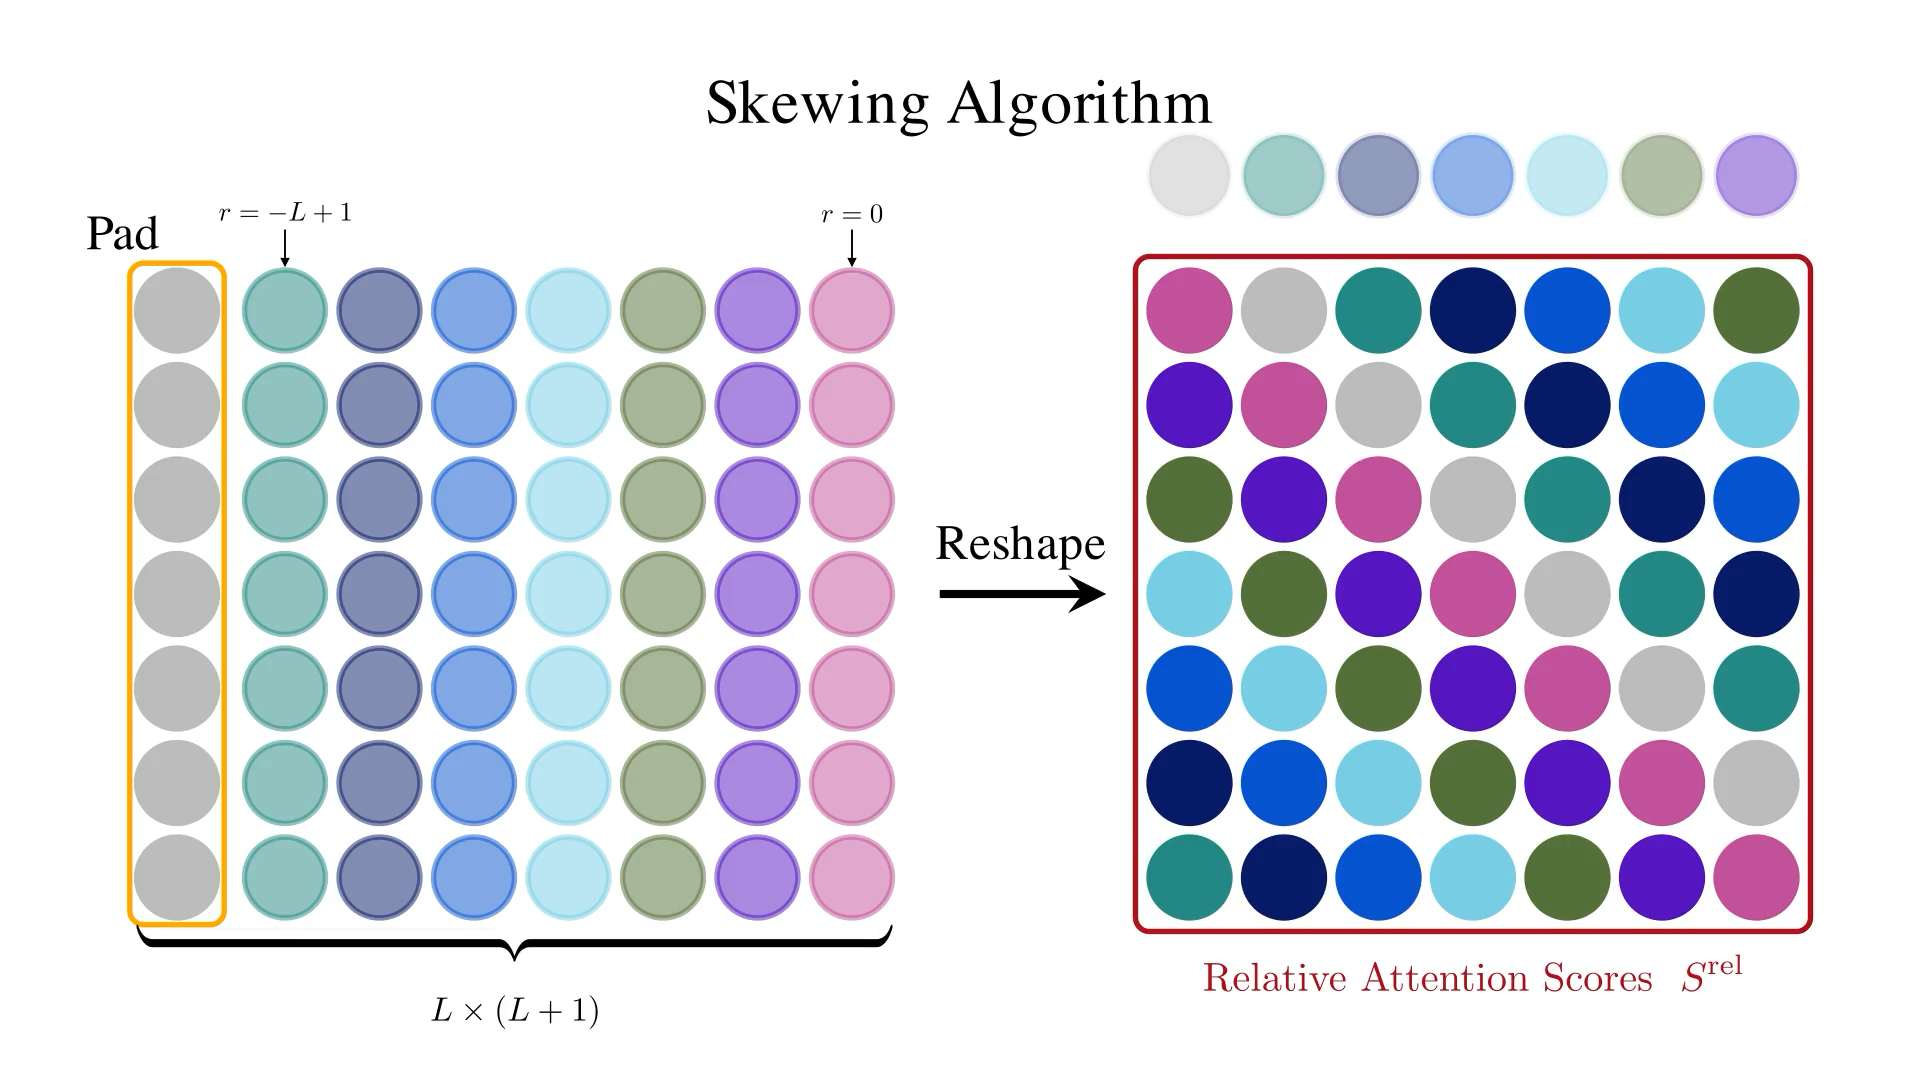

In [7]:
# Skew algorithm

# pad (on the left side)
padded_QEr = torch.nn.functional.pad(QEr, (1, 0))
print('padded_QEr:', padded_QEr.shape)

# Reshape
reshaped_QEr = padded_QEr.view(seq_len + 1, seq_len)
print('reshapreshaped_QEred:', reshaped_QEr.shape)

# Slice
S_rel = reshaped_QEr[-seq_len:, :]
print('S_rel:', S_rel.shape)

padded_QEr: torch.Size([12, 13])
reshapreshaped_QEred: torch.Size([13, 12])
S_rel: torch.Size([12, 12])


In [8]:
normalized_attention_scores = torch.softmax(
    (attention_scores + S_rel) / math.sqrt(d),
    dim=-1
)

output = torch.matmul(normalized_attention_scores, V)
print('output:', output.shape)

output: torch.Size([12, 512])
